<a href="https://colab.research.google.com/github/LCaravaggio/AnalisisPredictivo/blob/master/Kaggle/2023Q2/Un_primer_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
import cupy as cp
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split





In [17]:

X_train=pd.read_csv('dataset/train.csv')
X_test = pd.read_csv('dataset/test.csv')
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

y_train = X_train.averageRating
y_test = X_test.averageRating

X_train.drop(['averageRating'], axis=1, inplace=True)
X_test.drop(['averageRating'], axis=1, inplace=True)


X_pred=pd.read_csv('dataset/val.csv')
X_pred.fillna(0, inplace=True)

#Show difference between train and test by columns
#make a set of the columns that are in train but not in test
""" 
print(set(X.columns))
print(set(X_pred.columns)) """

C:\Users\ianda\AppData\Local\Temp\ipykernel_21172\3428640444.py:2: DtypeWarning: Columns (53,64) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test = pd.read_csv('dataset/test.csv')


' \nprint(set(X.columns))\nprint(set(X_pred.columns)) '

In [19]:

# Move the data to the GPU
X_train_gpu = cp.asarray(X_train)
y_train_gpu = cp.asarray(y_train)

In [20]:

# Train the model on the GPU

regr = XGBRegressor(n_estimators=1100,eta=0.025,max_depth=18,device="cuda",tree_method="hist",sampling_method="gradient_based",subsample=0.6) # type: ignore
#regr = XGBRegressor(n_estimators=1200, eta=0.35, max_depth=7, multi_strategy="multi_output_tree", min_child_weight=1, subsample=1, colsample_bytree=1, gamma=0, alpha=0)
print("Training a XGBRegressor")
regr.fit(X_train_gpu, y_train_gpu)
print("Finished training the XGBRegressor")


Training a XGBRegressor
Finished training the XGBRegressor


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:tagline: object, video: object

In [21]:
score = regr.score(X_test, y_test)

print("R^2 score on testing data: {:.4f}".format(score)) 
# 0.7 - 0.3819 | 0.6 - 0.3845 | 0.5 - 0.3867 | 0.4 - 0.3862
# 50 - 0.3862 | 60 - 0.3875 | 70 - 0.3886 | 75 - 0.3888 | 80 - 0.3886

# RMSE
from sklearn.metrics import mean_squared_error
y_pred = regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:tagline: object, video: object

In [15]:
from keras.models import Sequential
from keras.layers import Dense
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

# Normalize the data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Define the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train_norm.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam())

# Train the model
model.fit(X_train_norm, y_train, epochs=100, batch_size=32, validation_data=(X_test_norm, y_test),workers=16)




Epoch 1/100
27494/27494 [==============================] - 20s 732us/step - loss: 1.5624 - val_loss: 1.4778
Epoch 2/100
27494/27494 [==============================] - 20s 728us/step - loss: 1.4838 - val_loss: 1.4499
Epoch 3/100
27494/27494 [==============================] - 20s 729us/step - loss: 1.4673 - val_loss: 1.4418
Epoch 4/100
27494/27494 [==============================] - 20s 730us/step - loss: 1.4575 - val_loss: 1.4304
Epoch 5/100
27494/27494 [==============================] - 20s 727us/step - loss: 1.4493 - val_loss: 1.4373
Epoch 6/100
27494/27494 [==============================] - 20s 726us/step - loss: 1.4424 - val_loss: 1.4535
Epoch 7/100
27494/27494 [==============================] - 20s 726us/step - loss: 1.4367 - val_loss: 1.4262
Epoch 8/100
27494/27494 [==============================] - 20s 731us/step - loss: 1.4306 - val_loss: 1.4175
Epoch 9/100
27494/27494 [==============================] - 20s 728us/step - loss: 1.4251 - val_loss: 1.4136
Epoch 10/100
27494/27494 [==

In [16]:

# Evaluate the model
X_test = scaler.transform(X_test)
score = model.evaluate(X_test, y_test)
print("MSE on testing data: {:.4f}".format(score))

# Predict on test data
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))


3055/3055 [==============================] - 2s 495us/step - loss: 1.3446
MSE on testing data: 1.3446
3055/3055 [==============================] - 1s 458us/step
RMSE: 1.159579


In [ ]:

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.1, random_state=42)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Set the hyperparameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 1,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 1
}

# Train the LightGBM model
num_rounds = 1000
regr = lgb.train(params, train_data, num_rounds)

# Make predictions on the validation set
y_pred = regr.predict(X_val)

from sklearn.metrics import mean_squared_error

# Compute the mean squared error
mse = mean_squared_error(y_val, y_pred)

# Compute the root mean squared error
rmse = np.sqrt(mse)

# Print the root mean squared error
print("RMSE: {:.2f}".format(rmse))


In [ ]:

# Define the number of threads to use
#use max threads
from random import randint
num_threads = 16

# Define the random states to use
random_states = []
for i in range(3):
    random_states.append(randint(0, 1000))

# Define the training and testing data


# Define a function to train the model and return the R^2 score
def train_model(random_state):
    # Create a LinearForestRegressor with the specified random state
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
    regr = XGBRegressor(n_estimators=1100,eta=0.025,max_depth=17,device="cuda",tree_method="hist",sampling_method="gradient_based",subsample=0.6) # type: ignore
    #regr = XGBRegressor(n_estimators=1200, eta=0.35, max_depth=7, multi_strategy="multi_output_tree", min_child_weight=1, subsample=1, colsample_bytree=1, gamma=0, alpha=0)
    print("Training a XGBRegressor")
    regr.fit(X_train, y_train)
    print("Finished training the XGBRegressor")
    score = regr.score(X_test, y_test)

    print(f"R^2 score on testing data ({random_state}): {score:.4f}") 
    return score

# Use a ThreadPoolExecutor to run the function on multiple threads
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Submit the function to the executor for each random state
    futures = [executor.submit(train_model, random_state) for random_state in random_states]

    # Wait for all the futures to complete and get the results
    results = [future.result() for future in futures]

# Print the average R^2 score across all the random states
print("Average R^2 score across all random states: {:.4f}".format(sum(results) / len(results)))


In [7]:
from lineartree import LinearForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


regr = LinearForestRegressor(base_estimator=LinearRegression(),max_depth=37,max_features=1.0,n_estimators=200) # type: ignore
#regr = XGBRegressor(n_estimators=1200, eta=0.35, max_depth=7, multi_strategy="multi_output_tree", min_child_weight=1, subsample=1, colsample_bytree=1, gamma=0, alpha=0)
print("Training a XGBRegressor")
regr.fit(X_train, y_train)

print("Finished training the XGBRegressor")
score = regr.score(X_test, y_test)

print("R^2 score on testing data: {:.4f}".format(score)) 
# 0.7 - 0.3819 | 0.6 - 0.3845 | 0.5 - 0.3867 | 0.4 - 0.3862
# 50 - 0.3862 | 60 - 0.3875 | 70 - 0.3886 | 75 - 0.3888 | 80 - 0.3886
# 5142
# RMSE
from sklearn.metrics import mean_squared_error
y_pred = regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

Training a XGBRegressor
Finished training the XGBRegressor
R^2 score on testing data: 0.5226
RMSE: 0.970151


3055/3055 [==============================] - 1s 463us/step


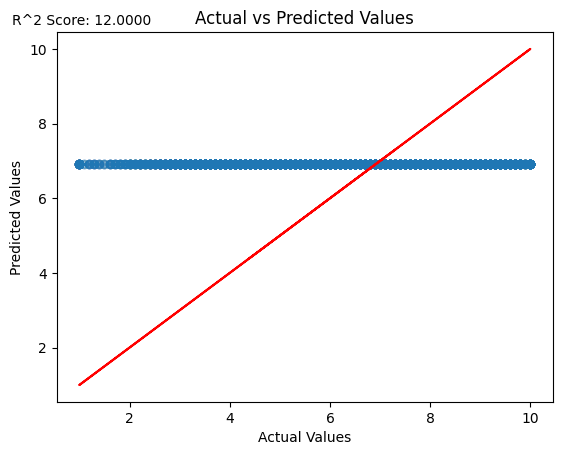

In [10]:

# Assume regr is your trained LinearForestRegressor
predictions = regr.predict(X_test).clip(0, 10)

# Create a scatter plot of predicted vs actual values with transparency
plt.scatter(y_test, predictions, alpha=0.05)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
#Subtitle with score
plt.text(0.05, 1.03, 'R^2 Score: {:.4f}'.format(score), ha='center', va='center', transform=plt.gca().transAxes)

# Plot a line for perfect correlation. This serves as a reference line.
plt.plot(y, y, 'r')

plt.show()

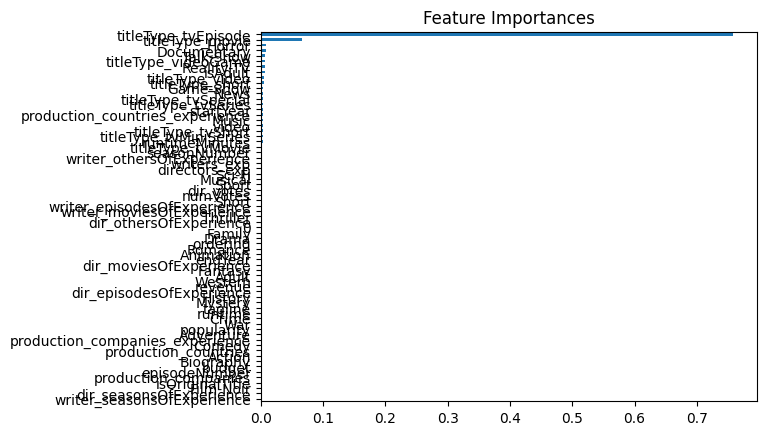

In [14]:
# Assume regr is your trained LinearForestRegressor
importances = regr.feature_importances_

# Convert to pandas Series for easier plotting
importances = pd.Series(importances, index=X.columns)

# Sort importances
importances = importances.sort_values()

# Plot
importances.plot(kind='barh')
plt.title('Feature Importances')
plt.show()


In [9]:
Yest = regr.predict(X_pred).clip(0, 10)
salida = pd.DataFrame(data={"averageRating": Yest})
salida.index = X_pred.index
salida.to_csv("predicciones/pred21.csv", sep=',',index=True,  index_label='Id')